# load

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')


import utils.data_utils as du
import utils.feature_utils as fu
import utils.preparation_utils as pu
import utils.model_utils as mu
import utils.viz_utils as vu

# Cấu hình hiển thị
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)
vu.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print("=== [PHASE 1] STARTING DIAGNOSTIC PIPELINE ===")

# 1. Load Data
print("\n1. Loading Raw Data...")
tables = du.load_olist_tables(
    data_path='data',
    tables_to_load=['orders', 'order_items', 'order_reviews', 'products', 
                    'sellers', 'customers', 'geolocation', 'product_category'],
    verbose=False
)

# 2. Merge Tables
print("2. Merging to Base Dataset...")
df_base = du.create_base_dataset(tables, merge_strategy='left')

# 3. Basic Filtering
print("3. Filtering Data...")
# Chỉ lấy đơn hàng đã giao & có review
df = du.filter_by_conditions(df_base, {'order_status': ['delivered']}, verbose=False)
df = df[df['review_score'].notna()].copy()

print(f"✓ Initial Dataset Ready: {df.shape}")

=== [PHASE 1] STARTING DIAGNOSTIC PIPELINE ===

1. Loading Raw Data...
2. Merging to Base Dataset...
Creating base dataset...
Starting with orders: (99441, 8)
After merge reviews: (99992, 11)
After merge order_items: (99992, 16)
After merge customers: (99992, 19)
After merge sellers: (99992, 22)
After merge products: (99992, 29)
After merge category translation: (99992, 30)

✓ Base dataset created: (99992, 30)
3. Filtering Data...
✓ Initial Dataset Ready: (96361, 30)


# feature

In [5]:
print("\n=== 1. CREATING DIAGNOSTIC FEATURES (POST-MORTEM) ===")

# --- A. LOGISTICS REALITY (Thực tế giao vận) ---
# Chuyển đổi sang datetime
date_cols = ['order_purchase_timestamp', 'order_approved_at', 
             'order_delivered_carrier_date', 'order_delivered_customer_date', 
             'order_estimated_delivery_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])


df['di_delay_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.total_seconds() / 86400
df['di_approval_days'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 86400
df['di_carrier_handover_days'] = (df['order_delivered_carrier_date'] - df['order_approved_at']).dt.total_seconds() / 86400
df = fu.process_product_pricing(df)
df = fu.process_geo_features(df, tables['geolocation'])

df['di_review_length'] = df['review_comment_message'].fillna('').apply(len)

df['int_delay_x_price'] = df['di_delay_days'] * df['total_price']
df['int_freight_per_km'] = df['total_freight'] / (df['distance_km'] + 1)

df = fu.create_target(df, threshold=3)

print(f"✓ Features Created (Optimized). Columns: {len(df.columns)}")


=== 1. CREATING DIAGNOSTIC FEATURES (POST-MORTEM) ===
✓ Features Created (Optimized). Columns: 43


# Split, pre processing

In [6]:
train_df, test_df, split_date = du.temporal_split(
    df, 
    date_col='order_purchase_timestamp',
    test_size=0.2
)

print(f"-> Train size: {train_df.shape[0]}")
print(f"-> Test size:  {test_df.shape[0]}")

Temporal split at: 2018-05-26 13:17:52
Train: (77088, 43) (2016-09-15 12:16:38 to 2018-05-26 13:12:54)
Test:  (19273, 43) (2018-05-26 13:17:52 to 2018-08-29 15:00:37)
-> Train size: 77088
-> Test size:  19273


In [7]:
numeric_cols = [
    # --- Diagnostic Features (Nguyên nhân trực tiếp) ---
    'di_delay_days',              # Key Feature: Số ngày trễ thực tế
    'di_approval_days',           # Thời gian duyệt đơn
    'di_carrier_handover_days',   # Thời gian chuẩn bị hàng
    'di_review_length',           # Độ dài review
    
    # --- Interaction Features (Biến tương tác mạnh) ---
    'int_delay_x_price',          # Trễ x Giá trị
    'int_freight_per_km',         # Phí ship / Km
    
    # --- Standard Features ---
    'total_price', 'total_freight', 'freight_ratio',
    'distance_km', 
    'product_weight_g', 'product_description_lenght', 'product_photos_qty',
    
 
]

categorical_cols = [
    'customer_state', 
    'seller_state', 
    'product_category_name_english',
    
]

# Các cột không dùng (ID, Text thô, Date)
cols_to_drop = [
    # ID & System cols
    'order_id', 'customer_id', 'seller_id', 'product_id', 'order_item_id',
    'review_id', 'order_status',
    
    # Date cols
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_carrier_date', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp',
    
    # Text cols & Redundant info (GÂY LỖI NẾU KHÔNG DROP)
    'review_comment_title', 'review_comment_message',
    'customer_city', 'seller_city',     # <--- Đã thêm
    'product_category_name',            # <--- Đã thêm (Dùng bản English thay thế)
    'review_score'                      # Target gốc
]

In [8]:
X_train_raw = train_df.drop(columns=['target'] + cols_to_drop, errors='ignore')
y_train = train_df['target']

X_test_raw = test_df.drop(columns=['target'] + cols_to_drop, errors='ignore')
y_test = test_df['target']

print("Checking for remaining object columns...")
obj_cols = X_train_raw.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    print(f"⚠️ WARNING: Still found object cols: {obj_cols}. Dropping them automatically.")
    X_train_raw = X_train_raw.drop(columns=obj_cols)
    X_test_raw = X_test_raw.drop(columns=obj_cols)

    

Checking for remaining object columns...
⚠️ WARNING: Still found object cols: ['customer_state', 'seller_state', 'product_category_name_english']. Dropping them automatically.


In [9]:
print("--- Processing Train Set ---")
X_train_processed, artifacts = pu.train_preparation_pipeline(
    X_train_raw,
    skewed_cols=['total_price', 'distance_km', 'int_delay_x_price'], # Log transform các biến lệch
    normal_cols=[c for c in numeric_cols if c not in ['total_price', 'distance_km', 'int_delay_x_price']],
    categorical_cols=categorical_cols,
    top_n_categories=20 # Gom nhóm các category nhỏ
)

--- Processing Train Set ---
  [1/5] Fitting Imputer...
  [2/5] Fitting Outlier Capper...
  [3/5] Applying Log Transform...
  [4/5] Checking Multicollinearity...
  [5/5] Fitting Scaler...
  [6/6] Encoding Categoricals...

⚠️  Found 4 columns with NaNs in Train (Missed by Imputer):
   List: ['product_length_cm', 'product_height_cm', 'product_width_cm', 'weight_log']
   -> Filled 'product_length_cm' with 0
   -> Filled 'product_height_cm' with 0
   -> Filled 'product_width_cm' with 0
   -> Filled 'weight_log' with 0


In [10]:
print("--- Processing Test Set ---")
X_test_processed = pu.test_preparation_pipeline(
    X_test_raw,
    artifacts=artifacts, # Dùng lại quy tắc từ Train
    skewed_cols=['total_price', 'distance_km', 'int_delay_x_price'],
    categorical_cols=categorical_cols
)

--- Processing Test Set ---


In [11]:
X_train_processed = pu.clean_column_names(pu.fill_forgotten_nans(X_train_processed))
X_test_processed = pu.clean_column_names(pu.fill_forgotten_nans(X_test_processed))

print(f"\nFinal Input Shape: {X_train_processed.shape}")


Final Input Shape: (77088, 23)


# train

Tuning LightGBM to maximize Diagnostic Power...

Tuning LightGBM with Optuna (30 trials)...
  Best AUC: 0.7907
  Best Params: {'learning_rate': 0.09659169202728615, 'num_leaves': 74, 'max_depth': 5, 'subsample': 0.7351840262274792, 'colsample_bytree': 0.6938470769517684, 'reg_alpha': 0.010807191454866036, 'reg_lambda': 0.014294981417094552, 'min_child_samples': 50}

--- Diagnostic Performance (Test Set) ---

FINAL TEST RESULTS (Threshold=0.5)
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     16084
           1       0.44      0.49      0.47      3189

    accuracy                           0.81     19273
   macro avg       0.67      0.69      0.68     19273
weighted avg       0.82      0.81      0.82     19273

ROC AUC: 0.7343
F2 Score: 0.4824


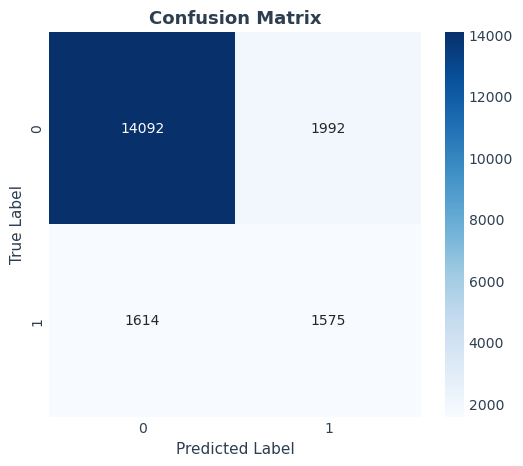


final AUC: 0.7343
⚠️ Note: AUC chưa đạt 0.8. Có thể do dữ liệu nhiễu hoặc hành vi khách hàng khó đoán.


In [12]:
print("Tuning LightGBM to maximize Diagnostic Power...")

model = mu.tune_lgbm_optuna(
    X_train_processed, 
    y_train,
    n_trials=30,        # Số lần thử nghiệm
    n_splits=3,         # Cross-validation theo thời gian
    time_limit=300      # Giới hạn 5 phút
)

print("\n--- Diagnostic Performance (Test Set) ---")
mu.evaluate_final_model(model, X_test_processed, y_test)
# Kiểm tra AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, model.predict_proba(X_test_processed)[:, 1])
print(f"\nfinal AUC: {auc:.4f}")

if auc < 0.8:
    print("⚠️ Note: AUC chưa đạt 0.8. Có thể do dữ liệu nhiễu hoặc hành vi khách hàng khó đoán.")
else:
    print("✅ Excellent: Mô hình đủ tin cậy để giải thích nguyên nhân.")

# SHAP


=== [STEP 7] ROOT CAUSE ANALYSIS (SHAP) ===

Computing SHAP values...

✓ SHAP values computed. Shape: (2000, 23)

Top 5 Most Important Features (by SHAP):
                 feature  mean_abs_shap  mean_shap
        di_review_length       0.547298  -0.029207
           di_delay_days       0.319233  -0.061824
di_carrier_handover_days       0.145185  -0.048358
  seller_zip_code_prefix       0.140599   0.004309
             distance_km       0.140391  -0.056768
✓ Saved SHAP plot to reports folder


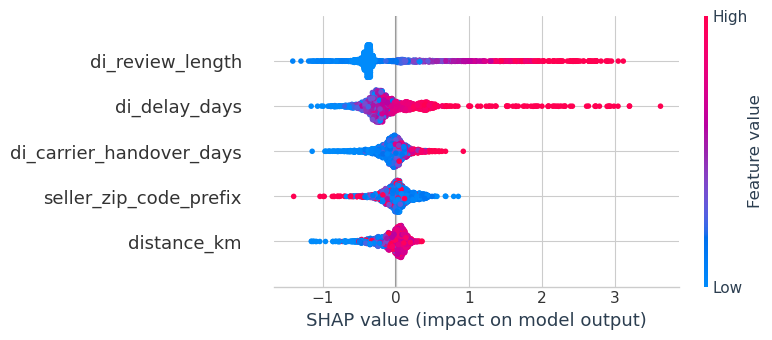


TOP 10 DRIVERS OF DISSATISFACTION:


,feature,mean_abs_shap,mean_shap
20,di_review_length,0.547298,-0.029207
11,di_delay_days,0.319233,-0.061824
13,di_carrier_handover_days,0.145185,-0.048358
4,seller_zip_code_prefix,0.140599,0.004309
19,distance_km,0.140391,-0.056768
2,total_freight,0.126861,-0.048285
3,customer_zip_code_prefix,0.121638,0.008022
0,num_items,0.110724,-0.004846
14,freight_ratio,0.101254,0.013929
22,int_freight_per_km,0.095630,0.036600


In [16]:
print("\n=== [STEP 7] ROOT CAUSE ANALYSIS (SHAP) ===")

# 1. Tính SHAP Values
# Lấy mẫu nhỏ (2000 dòng) để tính cho nhanh mà vẫn đủ đại diện
X_shap_sample = X_test_processed.sample(min(2000, len(X_test_processed)), random_state=42)

shap_out = mu.compute_shap_values(
    model=model,
    X_train=X_train_processed.sample(100, random_state=42), # Background data
    X_test=X_shap_sample,
    feature_names=X_test_processed.columns.tolist(),
    max_display=5, # Top 5 nguyên nhân
    plot=True       # Vẽ biểu đồ Beeswarm
)

# 2. Xuất bảng Top Drivers
shap_df = shap_out['feature_importance']
print("\nTOP 10 DRIVERS OF DISSATISFACTION:")
display(shap_df.head(10))


=== [STEP 8] INSIGHT DEEP DIVE ===
✓ Saved SHAP plot to reports folder


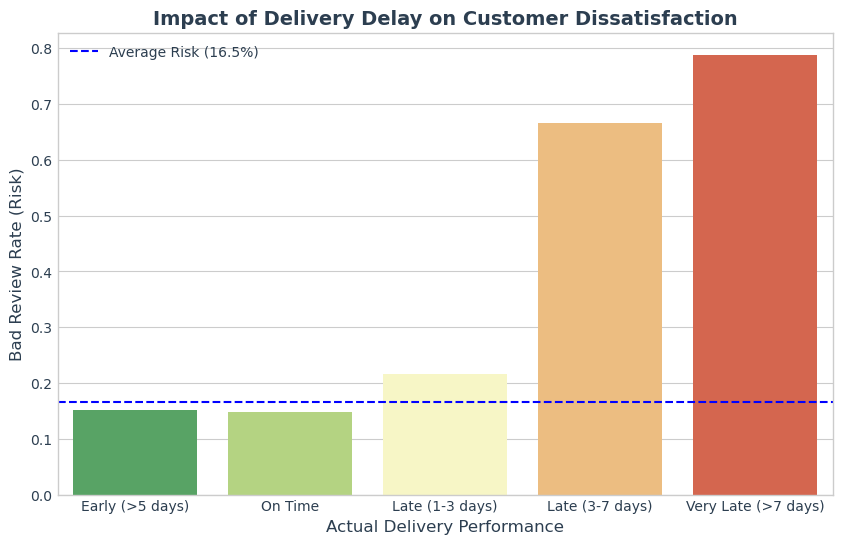

Insight: Biểu đồ cho thấy mức độ hài lòng giảm mạnh (Risk tăng) khi đơn hàng bị trễ, đặc biệt là trễ trên 3 ngày.


In [17]:
print("\n=== [STEP 8] INSIGHT DEEP DIVE ===")

# Vẽ biểu đồ: Tỷ lệ Bad Review theo mức độ Trễ hàng
if 'di_delay_days' in test_df.columns:
    plt.figure(figsize=(10, 6))
    
    # Phân nhóm ngày trễ
    df_plot = test_df.copy()
    df_plot['Delivery Status'] = pd.cut(
        df_plot['di_delay_days'], 
        bins=[-100, -5, 0, 3, 7, 100],
        labels=['Early (>5 days)', 'On Time', 'Late (1-3 days)', 'Late (3-7 days)', 'Very Late (>7 days)']
    )
    
    # Tính tỷ lệ Bad Review cho từng nhóm
    sns.barplot(data=df_plot, x='Delivery Status', y='target', palette='RdYlGn_r', errorbar=None)
    
    plt.title('Impact of Delivery Delay on Customer Dissatisfaction', fontsize=14)
    plt.ylabel('Bad Review Rate (Risk)', fontsize=12)
    plt.xlabel('Actual Delivery Performance', fontsize=12)
    
    # Vẽ đường trung bình
    avg_risk = df_plot['target'].mean()
    plt.axhline(avg_risk, color='blue', linestyle='--', label=f'Average Risk ({avg_risk:.1%})')
    plt.legend()
    
    
    plt.savefig('reports/impact_delivery.png', bbox_inches='tight', dpi=300)
    print("✓ Saved SHAP plot to reports folder")
    plt.show()
    print("Insight: Biểu đồ cho thấy mức độ hài lòng giảm mạnh (Risk tăng) khi đơn hàng bị trễ, đặc biệt là trễ trên 3 ngày.")